In [ ]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import operator
import folium
import pandas as pd
#from mpl_toolkits.basemap import Basemap
import json
import folium
from scipy import stats
import graphistry
graphistry.register(key='370c9675be7ab15766e38af1906aa8e77a1265cbcf26256dcc1eb6c223e5bf40')
import random
from dateutil.parser import parse
from networkx.algorithms import bipartite


%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#  <font color='red'> Reading cleaned Data  </font> 

In [2]:
data_folder = 'data/'

In [3]:
edges = pd.read_csv(data_folder + 'data_cleaned/edges.csv')
edges = edges.dropna(axis = 1, how = 'all')

addresses = pd.read_csv(data_folder + 'data_cleaned/addresses.csv')
addresses = addresses.dropna(axis = 1, how = 'all')

entities = pd.read_csv(data_folder + 'data_cleaned/entities.csv')
entities = entities.dropna(axis = 1, how = 'all')

intermediaries = pd.read_csv(data_folder + 'data_cleaned/intermediaries.csv')
intermediaries = intermediaries.dropna(axis = 1, how = 'all')

officers = pd.read_csv(data_folder + 'data_cleaned/officers.csv')
officers = officers.dropna(axis = 1, how = 'all')

In [4]:
# Select nodes, countries and country_code from all dataframes above and concat it with the edges in order to replace edges nodes with the countries 
entities_nodes = entities[['countries', 'node_id', 'node_type']]

intermediaries_nodes = intermediaries[['countries', 'node_id', 'node_type']]

officers_nodes = officers[['countries', 'node_id', 'node_type']]

nodes = pd.concat([entities_nodes , intermediaries_nodes , officers_nodes ], sort=True)

In [5]:
countries_counts = nodes.groupby(['countries','node_type']).count().unstack()
countries_counts.columns = countries_counts.columns.droplevel()
countries_counts = countries_counts.reset_index().replace(np.nan,0 )
countries_counts = countries_counts.groupby('countries')[['entity','intermediaire','officers']].apply(lambda x : x.sum())

#  <font color='red'> Data wrangling   </font> 
### 1)

**After cleaning data, we want to have a general idea about the countries involved in Panama papers as we focalise our project about countries. The first 3 plots enable us to see the top 15 countries involved in the different datasets (entities, officers and intermediairies). The idea is to see if they are repeated countries in all the datasets, if there is a country that dominates the plots, if the countries are rich or poor. Getting a clear idea about the countries may help us.**

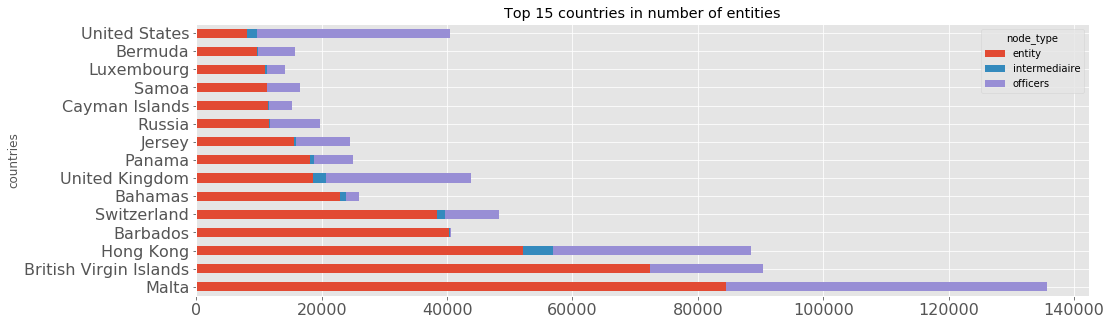

In [6]:
#count of countries using Addresses
countries_counts.sort_values('entity',ascending = False)[:15].plot.barh(stacked=True,title = 'Top 15 countries in number of entities',figsize=(16, 5),fontsize=16)

**The graph above shows the top 15 countries in number of entities. It is noticeable that the top 15 contains a lot of the offshore financial centers according to FMI, which is very logic. Companies look for low tax offshore jurisdiction to maximize their benefits.**

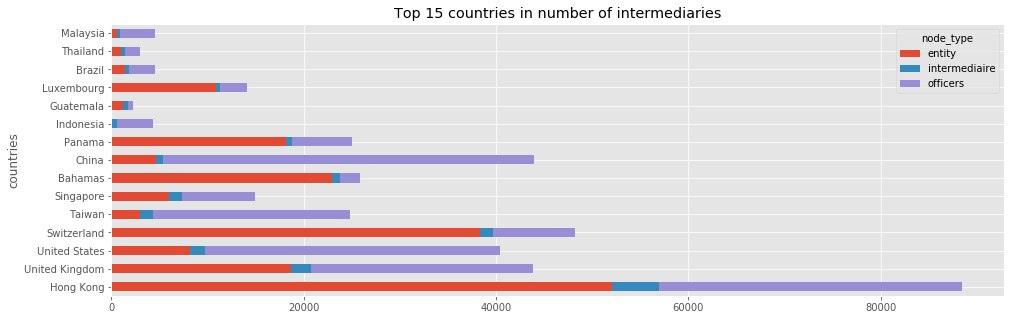

In [7]:
countries_counts.sort_values('intermediaire',ascending = False)[:15].plot.barh(stacked=True,title = 'Top 15 countries in number of intermediaries' ,figsize=(16, 5))

**The graph above shows the top 15 countries in number of intermediaries. The intermediaries (law firms, accounting firms, trust companies, banks, etc.) involve mainly in the phases of the identified decision-making cycle (advice, creation, maintenance, enforcement). It is noteworthy to say that Malta and British Virgin Islands does not exist in the top intermediairies even if they have the high number of entities. Also, note that Hong Kong is in the very top in the ranking.**

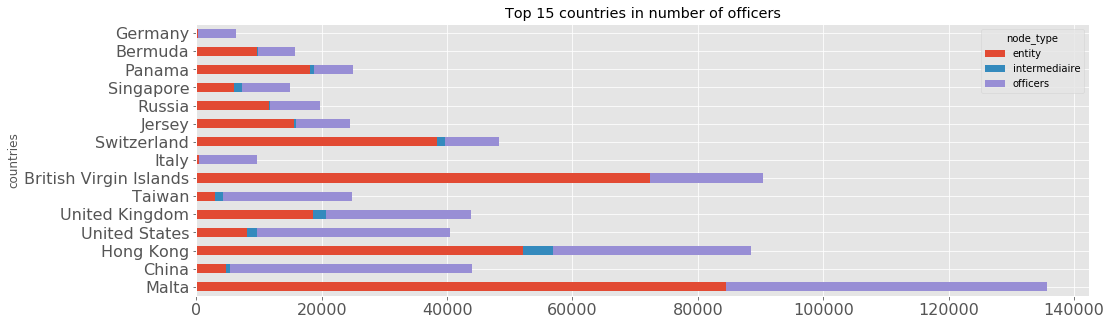

In [8]:
countries_counts.sort_values('officers',ascending = False)[:15].plot.barh(stacked=True,title = 'Top 15 countries in number of officers' ,figsize=(16, 5),fontsize=16)

**The graph above shows the top 15 countries in number of officers. It is noticeable to say that most countries involved in entities are present here, which is very logic. But, other countries appeared here, especially Germany, Italy and Russia. It means that officers may have a relationship with companies in those countries. We hope that we can explain that later.**


**General conclusion : Countries involved in Panama papers are around the word. The offshore entities are not related to Panama or American and Europeen countries. Companies, busniessmans, football players and even politicians all around the world had an issue with Panama papers.**

### 2)

**Intermediaries play an important role in decision making, which involves more people and juridiction related to Panama papers. That's  why, we want to understand more about them and plot the most active intermediaries.**

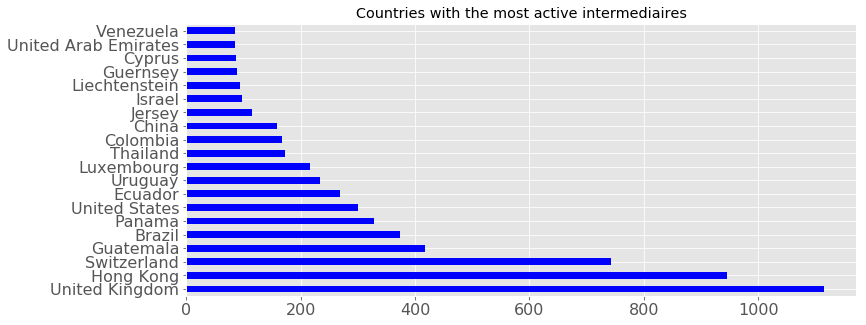

In [9]:
# Bar plot of most active intermediairies
intermediaries[intermediaries['status']== 'ACTIVE']['countries'].value_counts().head(20).plot.barh(
    title='Countries with the most active intermediaires', figsize=(12, 5),fontsize=16, color = 'b'
)

**Mossack Fonseca worked with intermediaries in more than 100 countries all over the globe. Their most active clients by number of offshore company incorporations were from the United Kingdom, Hong Kong and Switzerland.**

### 3)

**Other features may be releavent. We want to have an idea about the Incorporation year and the Inactivation year.** 

***Incorporation year:*** **the date when an offshore entity was created.**

***Inactivation year:*** **the date when a client told the agent to desactivate the offshore entity which could be recreated at a later date**

**The distribution of the evoluation of the incorposartions and inactivations over the years is an important thing to analyze.**

In [20]:
# We will plot next the distribution of the evoluation of the incorposartions over the years
entities_date = entities[['incorporation_date', 'inactivation_date']].copy()
entities_date.dropna(inplace= True)

entities_date['incorporation_date'] = entities_date['incorporation_date'].apply(lambda x: parse(x))
entities_date['inactivation_date'] = entities_date['inactivation_date'].apply(lambda x: parse(x))

entities_date['incorporation_date'] = entities_date['incorporation_date'].apply(lambda x : x.year)
entities_date['inactivation_date'] = entities_date['inactivation_date'].apply(lambda x : x.year)

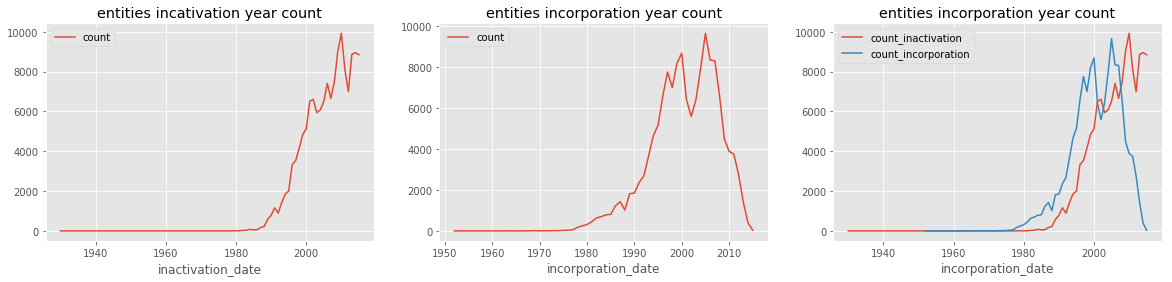

In [23]:
f, axarr = plt.subplots(1, 3, figsize=(20, 4))
f.subplots_adjust(hspace=0.75)

entities_date.groupby(['inactivation_date']).count().rename(columns= {'incorporation_date':'count'}).plot(
    title='entities incativation year count',  ax=axarr[0])

entities_date.groupby(['incorporation_date']).count().rename(columns= {'inactivation_date':'count'}).plot(
    title='entities incorporation year count',  ax=axarr[1])

entities_date.groupby(['inactivation_date']).count().rename(columns= {'incorporation_date':'count_inactivation'}).plot(
    title='entities incativation year count',  ax=axarr[2])

entities_date.groupby(['incorporation_date']).count().rename(columns= {'inactivation_date':'count_incorporation'}).plot(
    title='entities incorporation year count',  ax=axarr[2])



**The leaked files from Panama-based law firm Mossack Fonseca contain nearly 40 years of data. Mossack Fonseca’s clients have been rapidly deactivating companies since 2005. The number of incorporations of offshore entities has been decreasing rapidly since 2003.**

### 4)

**The following plot will give us the pourcentages of service providers which are the link between the entities and the clients.**

**Also we will plot the pourcentage of the data providers (The paper that leaked the data)**

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(16, 7))
f.subplots_adjust(hspace=0.75)

entities['service_provider'].value_counts().plot(kind='pie',  ax=axarr[0])
entities['sourceID'].value_counts()[:6].plot(kind='pie', ax= axarr[1])

**We can notice that Mossac Fonseca owe more than 50% of service providers, which is a Panamanian law firm and corporate service provider. It is the world's fourth largest provider of offshore financial services.**

In [ ]:
edges_countries = edges[['START_ID', 'END_ID', 'TYPE']].merge(nodes,how='left', left_on='START_ID', right_on='node_id').rename(columns= 
                                        {'countries':'countries_start', 'node_id':'node_id_start', 'node_type': 'node_type_start'})
edges_countries = edges_countries[['START_ID','END_ID','countries_start', 'node_id_start', 'TYPE', 'node_type_start']].merge(nodes,how='left', left_on='END_ID', 
                                                            right_on='node_id').rename(columns= 
                                        {'countries':'countries_end', 'node_type': 'node_type_end' }).drop(['node_id_start', 'node_id'], axis= 1)

In [ ]:
nodes = nodes[~nodes['countries'].isna()]
edges_countries = edges_countries[~edges_countries['countries_end'].isna() & ~edges_countries['countries_start'].isna()]

### Some folium to visualize the countries involved in Panama papers

In [ ]:
# Load the geojson file
geo_json = json.load(open('data/json/world_heavy.json'))

In [ ]:
# Create a list with all the countries code existing in the geojson
all_countries = []
for i in range (len(geo_json['features'])):
    all_countries.append(geo_json['features'][i]['properties']['adm0_a3_is'])

In [ ]:
# Load the data for the folium presentation
entities_f = pd.read_csv('data/data_folium/entities_.csv')
intermediaries_f = pd.read_csv('data/data_folium/intermediaries_.csv')
officers_f = pd.read_csv('data/data_folium/officers_.csv')

# Eliminate countries that don't exist in json file.
entities_f = entities_f[(entities_f['country_codes'].isin(all_countries))]
intermediaries_f = intermediaries_f[(intermediaries_f['country_codes'].isin(all_countries))]
officers_f = officers_f[(officers_f['country_codes'].isin(all_countries))]

In [ ]:
#Count the occurences of all countries in the dataset
#Return a dataset with the country code and the number of appearances

def create_count_data (data):
    count_df = pd.DataFrame([], all_countries)
    
    #Count: represents the count of presented country_code in the concerned dataframe 
    count_df['count'] = pd.np.zeros([len(count_df.index)])
    
    
    for key in count_df.index:
        count_df.loc[key,'count'] = len(data[data['country_codes'] == key])
    
    #Drop the 0 values.
    count_df = count_df[(count_df != 0).any(axis=1) == True]
    
    #Apply log function make the plot clearer 
    #count_df['count'] = np.log10(count_df['count'])
    
    count_df = count_df.reset_index()
    return count_df.drop_duplicates()

In [ ]:
count_entities = create_count_data(entities_f)
count_intermediaries = create_count_data(intermediaries_f)
count_officers = create_count_data(officers_f)

In [ ]:
mymap = folium.Map(zoom_start=8)



mymap.choropleth(geo_data=geo_json, 
         data=count_entities,
         columns=['index', 'count'],
         key_on='feature.properties.adm0_a3_is',
         fill_color='YlOrRd',name='Entities',legend_name='Entities')


mymap.choropleth(geo_data=geo_json,
                 data=count_intermediaries,
                 columns=['index', 'count'],
                 key_on='feature.properties.adm0_a3_is',
                 fill_color='YlOrRd',name='Intermediairies',legend_name='Intermediairies')

mymap.choropleth(geo_data=geo_json,
                 data=count_officers,
                 columns=['index', 'count'],
                 key_on='feature.properties.adm0_a3_is',
                 fill_color='YlOrRd',name='Officers',legend_name='Officers')
folium.LayerControl(collapsed=False).add_to(mymap)

mymap.save("plot.html")

mymap

**The map show the worldwide distribution of the three main kinds of actors : which are Offshore entities, intermediaries and officers. We notice that the three of them differ from each other on a global scale even though some countries are represented in all three categories.**

**Regarding the offshore entities, the presence of economic global powers is clear : US and Russia. But they are other effcicient hosting countries. Indeed, in Europe, Switzerland and Malta are leading with a very huge number comparing the other countries followed by Great Britain and Luxembourg. In South America, Panama has a large capital of offshore entities. In western Asia, United Arab Emirates is also leading.**

**The Intermediaries are once again most located in Switzerland and Great Britain, as they are known for the privacy of their bank services. Still, the distribution of the intermediaries is very similar to the offsore entities distribution on a global scale.**

**Finally, we notice the southern countries are more involved in the officer distribution. Usually officiers are settled in different juridiction than the company/private individual at the origin of the tax evasion.**

### Let's select have a deeper look with foluim visualisation

In [ ]:
def create_dataFrame_foluim(count_data):
    # reading data that contains country codes with size 2 and 3 AD	,AND for Andorra and clean it
    countries_codes = pd.read_csv('data/countries_countriesCode.csv',header=None)
    countries_codes['index'] = countries_codes.iloc[:,1]
    countries_codes['folium_index'] =  countries_codes.iloc[:,0]
    countries_codes['countries'] =countries_codes.iloc[:,4]
    countries_codes = countries_codes[['index', 'folium_index', 'countries']]
    
    # read longitude latitude dataframe and clean it 
    lon_lat = pd.read_csv('data/long_lat.csv',header=None,sep='\t' )
    lon_lat['folium_index'] = lon_lat.iloc[:,0]
    lon_lat['lat'] = lon_lat.iloc[:,1]
    lon_lat['lon'] = lon_lat.iloc[:,2]
    lon_lat['countries'] = lon_lat.iloc[:,3]
    lon_lat = lon_lat[['folium_index','lat','lon','countries' ]]
    
    # merge country codes and lon_lot
    merge_codes_lon_lat = countries_codes.merge(lon_lat, right_on='folium_index', left_on='folium_index')
    # merge the above dataframes
    count_long_lat = merge_codes_lon_lat.merge(count_data)
    return count_long_lat

In [ ]:
def create_foluim_map(count_data, save_name, coef):
    data = create_dataFrame_foluim(count_data)
    # Make an empty map
    m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=3)

    # prepare the circles to be plotted on the foluim map
    for i in range(0,len(data)):
        folium.Circle(
          location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
          popup=data.iloc[i]['countries_y'],
          radius=data.iloc[i]['count']*coef,
          color='blue',
          fill=True,
          fill_color='blue'
       ).add_to(m)
    # Save it as html
    m.save(save_name + '.html')
    return m

In [ ]:
m = create_foluim_map(count_entities, 'entities count in the world!', 20)

In [ ]:
m

**Above we could see the repartition of entities over countries, let's try to have a look at the connections between them. Our implementation is robust, we could select any country but in the next plot we will only consider Switzerland since it appeared in previous analysis as an interesting country**

In [ ]:
def get_edges(data, count_df):
    # if we want to prescise the type of the connexion we use egdes_type
    #edges_type = edges_countries[edges_countries['node_type_start'] == 'entity']
    edges_type = edges_countries.copy()
    # drop edges with nan values
    edges_countries_basemap = edges_type.dropna()[['countries_start', 'countries_end']]
    # drop duplicated edges
    edges_countries_basemap = edges_countries_basemap.drop_duplicates()
    # merge data dataframe with edges_countries_basemap, the data dataframe contain lon_lat information and index with only 2 charachters
    basem_map_df = data.merge(edges_countries_basemap, left_on ='countries_y', right_on='countries_end' )[['lat','lon', 'countries_start', 'countries_end','folium_index']]
    # eliminate self loops
    basem_map_df = basem_map_df[basem_map_df['countries_start']!=basem_map_df['countries_end']]
    data_indexed = data.set_index('countries_y')
    return basem_map_df, data_indexed

In [ ]:
from mpl_toolkits.basemap import Basemap
# Fix the dimension of the plot
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

# call the function create_dataFrame_foluim to get the country with their corresponding follium index and lon_lat
data = create_dataFrame_foluim(count_entities)
# get the edges of interest usinig count_entities dataFrame since we are interested in entities
basem_map_df, data_indexed = get_edges(data,count_entities )

# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
# tune the graph parameters
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0.2)
m.fillcontinents(color='#191919', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")

# Add a circles to the graph corresponding the count of entites
m.scatter(data['lon'], data['lat'],s=data['count']/5,alpha=0.6 ,cmap="Set1")

# for all langitude and latitude put the name of the country
for row in data.iterrows():
    plt.text(row[1]['lon'], row[1]['lat'], str(row[1]['countries_x']),fontsize=7,fontweight='bold', ha='left',va='top',color='k')
 
# set the plot name
plt.text( -170, -58,'Global view of country connexion ', ha='left', va='bottom', size=9, color='#555555' )

# This loop will create edges between the country of interest and other countries if an edges exists 
for  row in basem_map_df.iterrows():
    try:
        # Here we can choose if the we want the edges using country/ edges count .. 
        if data_indexed.loc[row[1]['countries_start']]['folium_index'] =='CH':
            m.drawgreatcircle(data_indexed.loc[row[1]['countries_start']]['lon'],data_indexed.loc[row[1]['countries_start']]['lat'] 
                              ,data_indexed.loc[row[1]['countries_end']]['lon']
                              ,data_indexed.loc[row[1]['countries_end']]['lat'],linewidth=2,color='orange',del_s=1)
    except: 
        continue
# Save as png
plt.savefig('Edges between countries', bbox_inches='tight')

**In order to investigate more links and connections between countries we will perform a deeper network analysis**

# <font color='red'> Network analysis </font> 

## We Construct a graph with country name as the identifiant of the node

In [ ]:
G_countries = nx.from_pandas_edgelist(edges_countries, source = 'countries_start', target = 'countries_end', edge_attr = 'TYPE', create_using = nx.DiGraph())

In [ ]:
print('Number of nodes(countries) = ', G_countries.number_of_nodes())
print('Number of edges = ', G_countries.number_of_edges())

## We tried to investigate the network properities in order to get nodes and edges importance.

####  Degree Centrality
Degree centrality starts with the assumption that the person with the most connections (edges) is the most important. Rather than returning a count it is the degree of the node divided by the total possible number of edges that the node could have. For the case of the directed graph the degree of the incoming vertices and outgoing vertices would likely be treated separately.

In other words centrality algorithms determine a node’s relative importance within a graph by looking at how connected it is to other nodes. It is used for instance to identify key players within organizations

In [ ]:
def compute_degree_centrality(graph):
    # compute degree centrality
    degree_centrality = nx.degree_centrality(graph)
    # Sort the list
    degree_centrality = sorted(degree_centrality.items(), key = operator.itemgetter(1), reverse = True)
    degree_centrality = pd.DataFrame(degree_centrality).rename(columns = {0:'country',1: 'centrality'})[1:len(degree_centrality) +1]
    return  degree_centrality.reset_index().rename(columns = {'index':'centrality rank'})
                              
print('Top 10 degree centralities: ')
G_countries_centrality = compute_degree_centrality(G_countries)
G_countries_centrality.head(10)

**Conclusion: From the dataframe above we can see the ranking of the most connected countries ie: United Kingdom has the most number of in + out edges.**

### Page rank

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.
It make a sens that we use it in our study since we can consider  countries as web pages.

In [ ]:
def compute_pagerank(graph):
    # compute the page rank
    pr = nx.pagerank_scipy(graph)
    # sort the list of page ranks
    pr = sorted(pr.items(), key = operator.itemgetter(1), reverse = True)
    pr = pd.DataFrame(pr).rename(columns = {0:'country',1: 'pr'})[1:len(pr)+1]
    return pr.reset_index().rename(columns = {'index':'pr rank'})

print('Page ranks : ')
G_countries_pr= compute_pagerank(G_countries)
G_countries_pr.head(10)

**Conclusion: Page rank uses the incoming links to perform it's ranking which is different from the degree centrality. From the dataframe above we can see that Hong Kong is the most influential country in our graph, also nodes that are connected to it shares some of it's influence.**

### Betweenes centrality

The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex. Betweenness centrality finds wide application in network theory: it represents the degree of which nodes stand between each other.

In [ ]:
def compute_btw_centrality(graph):
    # compute betweenes centrality
    btw_centrality = nx.betweenness_centrality(graph)
    # sort the list of betweenes centrality
    btw_centrality = sorted(btw_centrality.items(), key = operator.itemgetter(1), reverse = True)
    btw_centrality = pd.DataFrame(btw_centrality).rename(columns = {0:'country',1: 'btw_centrality'})[1:len(btw_centrality)]
    return btw_centrality.reset_index().rename(columns = {'index':'btw_centrality rank'})

print('Betweenness centrality: ')
G_countries_btw_centrality = compute_btw_centrality(G_countries)
G_countries_btw_centrality.head(10)

**Conclusion: As we can see United Kingdom, Switzerland... serve as bdriges from one part of graph to an other.**

<font color='red'> General conclusions: </font> 
We can see that some countries serves more as brdiges such as Panama but it does not appear in pageRank. We can conclude that the most important nodes of our graph are Hong Kong, Switzerland, United Kingdom and United States since the figure in the top 4 for all algorithms studied above.

### edge_betweenness_centrality

In [ ]:
def edge_betweenness_centrality(graph):
    # compute betweenes centrality
    edge_btw_centrality = nx.edge_betweenness_centrality(graph)
    # sort the list of betweenes centrality
    edge_btw_centrality = sorted(edge_btw_centrality.items(), key = operator.itemgetter(1), reverse = True)
    edge_btw_centrality = pd.DataFrame(edge_btw_centrality).rename(columns = {0:'country',1: 'btw_centrality'})[1:len(edge_btw_centrality)]
    return edge_btw_centrality.reset_index().rename(columns = {'index':'btw_centrality rank'})

print('Betweenness centrality: ')
G_countries_edge_btw_centrality = edge_betweenness_centrality(G_countries)
G_countries_edge_btw_centrality.head(10)

## We constructed a bipartite graph with two sets of nodes, the first one represents countries and the second one represents country names.

In [ ]:
## Keep only edges with known countries
edges_countries = edges_countries[~(edges_countries['countries_start'].isna()) & ~( edges_countries['countries_end'].isna())]

## Selecting edges having intermediaries involved
edges = edges_countries[(edges_countries['node_type_start']=='intermediaire') |( edges_countries['node_type_end']=='intermediaire')  ]

# The goal of the following manipulation is to keep only unique node_id so that we won't have redundant nodes
unique_nodes_start = edges[['node_type_start','START_ID','countries_start']]
unique_nodes_start = unique_nodes_start.drop_duplicates()

# keep nodes end wich represents the arriving nodes for edges
unique_nodes_end   = edges[['node_type_end','END_ID','countries_end']]
unique_nodes_end = unique_nodes_end.drop_duplicates()

# keep only a unique list of nodes, which is the union of START_ID and END_ID
unique = list(set(unique_nodes_start['START_ID']) | set(unique_nodes_end['END_ID']))
unique_nodes = nodes.loc[nodes['node_id'].isin(unique)]

## unique list of countries involved
countries = set(unique_nodes.countries.unique())

In [ ]:
## Create graph 
G = nx.Graph()
countries = unique_nodes.countries.unique()

# Add nodes to graph that contains the country name 
for row in countries:
        G.add_node(row)

# Add nodes with the node_id and create edges between the nodes and the country name
for n,row in unique_nodes.iterrows():
    G.add_node(row.node_id)
    G.add_edge(row.countries,row.node_id,node_type=row.node_type)

In [ ]:
print('Number of nodes = ', G.number_of_nodes())
print('Number of edges = ', G.number_of_edges())

In [ ]:
# Check if graph is Bipartite
bipartite.is_bipartite(G)

**Bipartite network projection will be used to compress information from our bipartite graph, we will choose the weighting method which will take into account the number of commun association between countries**

In [ ]:
# Project bipartite graph to countries
G_p = bipartite.weighted_projected_graph(G,set(countries))

In [ ]:
print('Betweenness centrality: ')
G_countries_edge_btw_centrality = edge_betweenness_centrality(G_p)
G_countries_edge_btw_centrality.head(10)

**Visualization**

**With the graphistry library, (after requesting a API key) we could have a highly sophiesticated and interactive graph. In the following cell we represented the countries and edges as in graph G_p :ie
edges between countries are weighted and represent the number of connections. For our case we consider connections between intermediairies**

In [ ]:
# Below a navigator will be opened in which you can select a node and see it's properties and it's connexions.
graphistry.nodes(G_p.nodes()).edges(G_p.edges()).settings(url_params={'play': 0}).bind(source='src', destination='dst',node='nodeid').plot(G_p)      

### Reading indicators dataframes financial secrecy index

**financial secrecy index**

The Financial Secrecy Index (FSI) ranks jurisdictions according to their secrecy and the scale of their offshore financial activities. It is a tool for understanding global financial secrecy, tax havens or secrecy jurisdictions, and illicit financial flows or capital flight.

In [ ]:
# Read the excel file 
fsi = pd.read_excel(data_folder + 'fsi.xlsx')
# drop columns that we judge as irrelevant for our analysis
fsi.drop(['FSI Value6', 'Narrative Report', 'FSI Share7'], axis=1, inplace= True)
# give more meaningful names to columns
fsi.rename(columns={'Secrecy Score4': 'secrecy_score','Global Scale Weight5':'global_scale'}, inplace= True)
# drop the NaN values
fsi = fsi.dropna()

#### fsi dataset cleaning : 

In [ ]:
# This dataset is used to add the country code into the fsi dataset
codes = pd.read_csv(data_folder + 'countries_countriesCode.csv')
codes = codes[['AND','Andorra']]

In [ ]:
# The name of countries contains 2 or 2.3 in the end, we removed them 
fsi['Jurisdiction'] = fsi['Jurisdiction'].map(lambda x: x.rstrip('22,3'))
# add countries code to fsi dataset to merge it then with other datasets
fsi = fsi.merge(codes,how='left',left_on='Jurisdiction',right_on='Andorra')

In [ ]:
# 2 countries that appears a lot in our datasets with a confused name: we solve the problem manually
fsi['AND'][1]='USA'
fsi['AND'][8]='ARE'
fsi['Jurisdiction'][8] = 'United Arab Emirates'
fsi['Jurisdiction'][1] = 'United States'

In [ ]:
# rename the name if the column (We are going to compare 2 ranks, so it would be easy to specify of each rank)
fsi = fsi.rename(index=str, columns={"Rank": "secrecy_rank"})

In [ ]:
fsi.head()

### Correlation between the rank of involved countries and the bank secrecy rank of the country

In [ ]:
def rank_from_count_dataset(data,column_name): 
    '''
    Method that take the count datasets of intermediaires, entities and officers.
    
    inputs : - data : Count datasets containing the number of appearence of the country in the dataset.
             - column_name : the name of the new column containing the rank
             
    output : - data : same dataset with a rank column
    '''
    # sort values according to count
    data = data.sort_values('count',ascending=False).reset_index()
    data= data.drop(['level_0'],axis=1).reset_index()   
    # rename rank column into column_name 
    data = data.rename(index=str, columns={"level_0": column_name})
    # Add 1 to the rank column (because the first one is ranked 1 not 0)
    data[column_name] = data[column_name].apply(lambda x : x+1)
    return data

To study the relationship between the ranks, we used spearmans rank correlation since it's appropriate for ordinal varaiables

In [ ]:
def compute_correlation (data,column_name): 
    '''
    Method that compute the rank correlation between the secrecy_rank and the country_rank.
    
    inputs : - data : Count datasets containing the rank of the country in the dataset.
             - column_name : the name of the column containing the rank.
             
    output : - rank correlation
    '''
    
    # merge fsi dataframe with data, data 
    merged = fsi.merge(data, right_on="index",left_on="AND", how = "left")[[column_name,'secrecy_rank','Jurisdiction','index']]
    # Drop Nan values
    merged = merged.dropna()
    return stats.spearmanr(merged[column_name],merged['secrecy_rank'])

In [ ]:
# get count_intermediaries rank
count_intermediaries_rank = rank_from_count_dataset(count_intermediaries,"intermediairies_rank")
# get count_entities rank
count_entities_rank = rank_from_count_dataset(count_entities,"entities_rank")
# get count_officers rank
count_officers_rank = rank_from_count_dataset(count_officers,"officers_rank")

**Compute the correlation between the intermediaries rank and secrecy_rank :**

In [ ]:
compute_correlation(count_intermediaries_rank,"intermediairies_rank")[0]

**Compute the correlation between the entities rank and secrecy_rank :**

In [ ]:
compute_correlation(count_entities_rank,"entities_rank")[0]

**Compute the correlation between the officers rank and secrecy_rank :**

In [ ]:
compute_correlation(count_officers_rank,"officers_rank")[0]

**Conclusion:** 

from above values we can constat that there is an important correlation between the rank calculated from panama papers and fsi ranks. Officers are the most correlated with the secrecy rank. Those persons or companies plays a role in an offshore entity. They chose tax havens to avoid the secrecy control and be able to invest as much money as they want.

### Correlation between the rank of countries concerning the secrecy rank and the graph study: 

In this part, we wanted to focalise more on the fsi ranking. We searched the correlation between the network properities explained above (page rank, betweeness centrality and degree centrality) and the secrecy rank.

In [ ]:
def correlation_fsi_graph_metrics(data,metric):
    '''
    Method that compute the rank correlation between the secrecy_rank and the country_rank.
    
    inputs : - data : dictionnary given from networkx expressing an aspect for a graph.
             - metric : the network property computed above
             
    output : - rank correlation
    '''
    
    # Merge data the fsi dataset:
    fsi_data = fsi.merge(data, right_on="country",left_on="Jurisdiction", how = "left")[[metric + ' rank','secrecy_rank','country']]
    # Drop Nan values
    fsi_data = fsi_data.dropna()
    # Compute the correlation
    return (stats.spearmanr(fsi_data[metric + ' rank'],fsi_data['secrecy_rank']))

### Page rank :

In [ ]:
correlation_fsi_graph_metrics(G_countries_pr,'pr')[0]

### Betweeness centrality : 

In [ ]:
correlation_fsi_graph_metrics(G_countries_btw_centrality, 'btw_centrality')[0]

### Degree centrality :

In [ ]:
correlation_fsi_graph_metrics(G_countries_centrality,'centrality')[0]

**Conclusion :** 

From the above scores, we can conclude that there is an important correlation between the network properties and fsi rank. We can confirm that the financial secrecy is related to Panama papers. Tax havens or secrecy jurisdictions attract illicit financial flows. Those countries are basically offshore center that provides financial services to nonresidents. That's why companies and individuals chose those jurisdictions to invest money. 

**World Happiness Index**

In [ ]:
# Merge the code countries with happiness data set to have a code country in happiness dataset
codes = pd.read_csv(data_folder + 'countries_countriesCode.csv')

In [ ]:
# Read the data
happiness = pd.read_csv(data_folder+'2015.csv')

In [ ]:
# Merge the datasets
happiness = happiness.merge(codes, right_on="Andorra",left_on="Country", how = "left")[["Happiness Rank",'Country','AND']]


In [ ]:
happiness.head()

In [ ]:
def correlation_happiness_ranks(happiness,ranks,types):
    merged = happiness.merge(ranks, right_on="index",left_on="AND", how = "left")[["Happiness Rank",types,'AND']]
    # Drop Nan values
    merged = merged.dropna()
    return stats.spearmanr(merged[types],merged['Happiness Rank'])

In [ ]:
correlation_happiness_ranks(happiness,count_intermediaries_rank,'intermediairies_rank')[0]

In [ ]:
correlation_happiness_ranks(happiness,count_officers_rank,'officers_rank')[0]

In [ ]:
correlation_happiness_ranks(happiness,count_entities_rank,'entities_rank')[0]